In [1]:
%load_ext autoreload
%autoreload 2

https://www.scitepress.org/Papers/2016/57407/57407.pdf

In [2]:
import os
import io
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from netpois import data_utils, utils

2023-05-23 12:12:55.949938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 12:12:59.466147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64::/home/giorgioseveri/.local/lib
2023-05-23 12:12:59.466344: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64::/home/giorgioseveri/.local/lib
2023-05-23 1

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
# Change this to point to the dataset directory
base_path = ""
base_dir = f"{base_path}/ISCXVPN/NonVPN/non_vpn_zeek_all"

In [4]:
nonvpn_dirs = [os.path.join(base_dir, i) for i in os.listdir(base_dir)]
print("Number of non-VPN directories:", len(nonvpn_dirs))

Number of non-VPN directories: 109


In [5]:
indicator_types = {
    "video": [
        "youtube",
        "vimeo",
        "netflix",
        "hangouts_video",
        "skype_video",
        "facebook_video",
    ],
    "file": ["scp", "sftp", "ftps", "skype_file"],
    "audio": ["voip", "facebook_audio", "hangouts_audio", "skype_audio", "spotify"],
    "chat": [
        "AIMchat",
        "aim_chat",
        "facebook_chat",
        "ICQchat",
        "gmailchat",
        "hangouts_chat",
        "hangout_chat",
        "icq_chat",
        "skype_chat",
        "facebookchat",
    ],
    "email": ["email"],
}

dirs_by_type = {
    k: [i for i in nonvpn_dirs if any([ind in i for ind in v])]
    for k, v in indicator_types.items()
}

# Sum of all non-VPN directories
print("Total number of non-VPN directories:", sum([len(i) for i in dirs_by_type.values()]))

# Find the dirs in nonvpn_dirs that are not in dirs_by_type
dirs_not_in_type = [
    i for i in nonvpn_dirs if not any([i in j for j in dirs_by_type.values()])
]
print(dirs_not_in_type)

Total number of non-VPN directories: 109
[]


In [6]:
def read_conn_log(dpth: str) -> pd.DataFrame:
    cols_to_drop = [
        "local_orig",
        "local_resp",
        "missed_bytes",
        "history",
        "orig_ip_bytes",
        "resp_ip_bytes",
        "tunnel_parents",
    ]
    separator = "\t"
    set_separator = ","

    with open(os.path.join(dpth, "conn.log")) as f:
        conn_log_lines = f.readlines()

    # Find the line starting with #fields
    fields_line = [i for i in conn_log_lines if i.startswith("#fields")][0].strip()
    fields = fields_line.split(separator)[1:]

    # Remove all lines starting with #
    conn_log_lines = [i.strip() for i in conn_log_lines if not i.startswith("#")]

    # Create dataframe from lines, with fields as column names
    df = pd.DataFrame(
        [i.strip().split(separator) for i in conn_log_lines], columns=fields
    )

    # Drop columns
    df = df.drop(columns=cols_to_drop)

    return df


In [7]:
raw_cls = []
raw_cls_dict = {}

for type, dirs in tqdm(dirs_by_type.items()):
    print(f"{type} has {len(dirs)} directories")
    raw_cls_dict[type] = []

    for d in dirs:
        # Load the conn.log file in the directory

        df = read_conn_log(d)
        raw_cls_dict[type].append(df.copy())

        df["label"] = type

        raw_cls.append(df)


  0%|          | 0/5 [00:00<?, ?it/s]

video has 26 directories


 20%|██        | 1/5 [00:00<00:02,  1.69it/s]

file has 32 directories


 40%|████      | 2/5 [00:01<00:02,  1.02it/s]

audio has 27 directories


 60%|██████    | 3/5 [00:03<00:02,  1.47s/it]

chat has 20 directories


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

email has 4 directories


In [8]:
unified_cl = pd.concat(raw_cls)
# Fill 0s instead of '-' in orig_bytes and resp_bytes
unified_cl["orig_bytes"] = unified_cl["orig_bytes"].replace("-", 0).astype(int)
unified_cl["resp_bytes"] = unified_cl["resp_bytes"].replace("-", 0).astype(int)
display(unified_cl)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,orig_pkts,resp_pkts,label
0,1427719318.827184,CZ0pV112WUWIVSvwEk,131.202.240.150,48752,131.202.244.3,53,udp,dns,0.000447,34,141,SF,1,1,video
1,1427719318.827195,CPDegM2YyEaVvyA8jh,131.202.240.150,48752,131.202.244.5,53,udp,dns,0.000340,34,141,SF,1,1,video
2,1427719318.827201,CPloEY19hXqRSLce2,131.202.240.150,48752,131.202.6.3,53,udp,dns,0.001184,34,141,SF,1,1,video
3,1427719319.565229,C7rYNp2mBZYHnCQOSj,131.202.240.150,11501,131.202.244.5,53,udp,dns,0.000424,34,141,SF,1,1,video
4,1427719319.577184,C4aGOf1WtuLwqFL8x9,131.202.240.150,13185,131.202.244.5,53,udp,dns,0.000347,34,141,SF,1,1,video
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1433533394.395594,CoEZ2eIS8hAMuSKM9,10.0.2.15,42899,157.56.53.47,12350,tcp,-,0.085096,5,5,OTH,2,2,email
282,1433533653.399529,CI5YrP1haqAhTWWlFa,10.0.2.15,50878,69.167.160.102,123,udp,ntp,0.047182,48,48,SF,1,1,email
283,1433533454.405452,CzX31E1lnxVf1cFymb,10.0.2.15,50956,157.56.192.53,443,tcp,-,0.224027,453,149,OTH,2,2,email
284,1433532341.915686,CPpv8b1DyxSxk1Hic2,10.0.2.15,43558,64.233.183.16,993,tcp,-,1344.434196,13736,49624,OTH,540,768,email


## Connection diversity

[('audio', 260443), ('file', 87149), ('chat', 13170), ('email', 8798), ('video', 4685)]


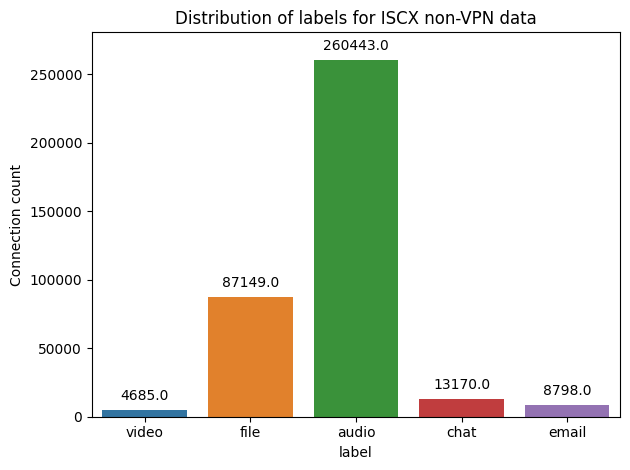

In [9]:
label_count = Counter(unified_cl["label"])
print(label_count.most_common())

# Plot the distribution of labels
ax = sns.countplot(x="label", data=unified_cl)
# Put the number of each label on top of the bar
for p in ax.patches:
    ax.annotate(
        p.get_height(),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )
# Add some padding to the top of the bar
plt.ylim(0, max(label_count.values()) + 20000)
plt.ylabel("Connection count")
plt.title("Distribution of labels for ISCX non-VPN data")
plt.tight_layout()
plt.show()

## Data exchange concentration

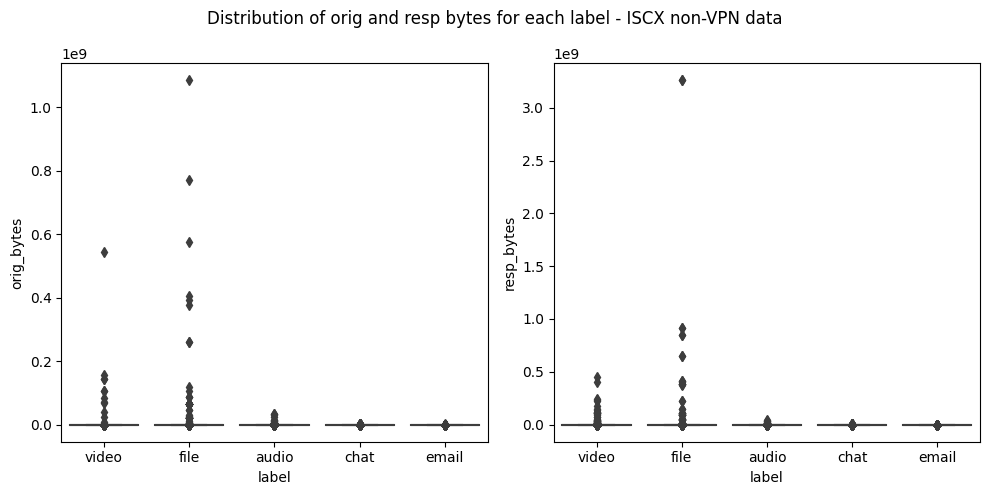

In [10]:
# Plot the distribution of orig and resp bytes for each label
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(x="label", y="orig_bytes", data=unified_cl, ax=ax[0])
sns.boxplot(x="label", y="resp_bytes", data=unified_cl, ax=ax[1])
plt.suptitle("Distribution of orig and resp bytes for each label - ISCX non-VPN data")
plt.tight_layout()
plt.show()


In [11]:
print(unified_cl[unified_cl["label"] == "chat"]["proto"].value_counts())
print(unified_cl[unified_cl["label"] == "email"]["proto"].value_counts())

udp     11649
icmp     1037
tcp       484
Name: proto, dtype: int64
udp     7826
icmp     681
tcp      291
Name: proto, dtype: int64


In [12]:
for label in sorted(unified_cl["label"].unique()):
    print("\nLabel:", label)
    print("Unique orig IPs:")
    print(unified_cl[unified_cl["label"] == label]["id.orig_h"].value_counts())
    print("Unique resp IPs:")
    print(unified_cl[unified_cl["label"] == label]["id.resp_h"].value_counts())


Label: audio
Unique orig IPs:
fe80::21a0:b1ce:a198:1da8    34673
131.202.243.9                34534
fe80::2c5a:e25e:653f:8c01    20256
131.202.242.93               20114
fe80::9897:a90b:afe1:7058    18311
                             ...  
145.255.165.91                   1
178.216.8.30                     1
193.138.187.54                   1
114.41.132.126                   1
128.65.249.132                   1
Name: id.orig_h, Length: 872, dtype: int64
Unique resp IPs:
224.0.0.252        110813
ff02::1:3          107834
255.255.255.255     14510
131.202.244.5        4240
224.0.0.251          3243
                    ...  
36.62.83.157            1
222.220.125.62          1
166.172.189.62          1
188.18.207.168          1
131.202.240.45          1
Name: id.resp_h, Length: 915, dtype: int64

Label: chat
Unique orig IPs:
131.202.240.242              1605
131.202.240.87               1373
131.202.240.117               981
131.202.240.93                976
fe80::7d39:f86f:fc49:f07c    

In [13]:
all_types = unified_cl["label"].unique()

In [14]:
from datetime import datetime

for conn_type in sorted(all_types):
    type_cl = unified_cl[unified_cl["label"] == conn_type].copy()
    type_cl["ts"] = type_cl["ts"].astype(float)
    print("\nType:", conn_type, "|", "Size:", type_cl.shape)
    # print(type_cl["ts"].min())
    # Convert timestamp to datetime
    print("Start date:", datetime.fromtimestamp(type_cl["ts"].min()))
    # print(type_cl["ts"].max())
    print("End date:", datetime.fromtimestamp(type_cl["ts"].max()))


Type: audio | Size: (260443, 15)
Start date: 2015-03-30 09:10:55.565768
End date: 2015-04-29 10:49:32.727282

Type: chat | Size: (13170, 15)
Start date: 2015-04-13 10:49:35.426480
End date: 2015-05-25 13:23:23.902048

Type: email | Size: (8798, 15)
Start date: 2015-05-25 12:52:39.110774
End date: 2015-06-05 15:48:00.217946

Type: file | Size: (87149, 15)
Start date: 2015-03-31 14:32:50.309114
End date: 2015-05-04 14:15:48.222627

Type: video | Size: (4685, 15)
Start date: 2015-03-30 08:41:57.277719
End date: 2015-04-01 14:13:12.991874


In [15]:
train_cls, test_cls = {}, {}
for conn_type in sorted(all_types):
    type_cl = unified_cl[unified_cl["label"] == conn_type].copy()
    type_cl["ts"] = type_cl["ts"].astype(float)
    type_cl.sort_values(by="ts", inplace=True)
    print("Type:", conn_type, "Size:", type_cl.shape)
    splitting_point = math.floor(len(type_cl) * 0.6)
    type_train_cl = type_cl.iloc[:splitting_point].copy()
    type_test_cl = type_cl.iloc[splitting_point:].copy()
    # type_train_cl, type_test_cl = train_test_split(type_cl, test_size=0.4, random_state=42)
    train_cls[conn_type] = type_train_cl
    test_cls[conn_type] = type_test_cl

print("\nTrain connections sizes:")
for conn_type, df in train_cls.items():
    assert len(df["label"].unique()) == 1
    assert df["label"].unique()[0] == conn_type
    df.drop(columns=["label"], inplace=True)
    print("Shapes:", conn_type, df.shape)

print("\nTest connections sizes:")
for conn_type, df in test_cls.items():
    assert len(df["label"].unique()) == 1
    assert df["label"].unique()[0] == conn_type
    df.drop(columns=["label"], inplace=True)
    print("Shapes:", conn_type, df.shape)

Type: audio Size: (260443, 15)
Type: chat Size: (13170, 15)
Type: email Size: (8798, 15)
Type: file Size: (87149, 15)
Type: video Size: (4685, 15)

Train connections sizes:
Shapes: audio (156265, 14)
Shapes: chat (7902, 14)
Shapes: email (5278, 14)
Shapes: file (52289, 14)
Shapes: video (2811, 14)

Test connections sizes:
Shapes: audio (104178, 14)
Shapes: chat (5268, 14)
Shapes: email (3520, 14)
Shapes: file (34860, 14)
Shapes: video (1874, 14)


In [16]:
internal_prefixes = ("131.202")
attacker_ips = ()

In [17]:
train_dfs = {}
test_dfs = {}

for conn_type, cl in train_cls.items():
    trn_df, _, _ = data_utils.process_zeek_csv(
        conn_log=cl,
        internal_prefixes=internal_prefixes,
        attacker_ips=attacker_ips,
        t_window=30,
        remove_int_int=False,
        verbose=True,
    )
    train_dfs[conn_type] = trn_df

for conn_type, cl in test_cls.items():
    tst_df, _, _ = data_utils.process_zeek_csv(
        conn_log=cl,
        internal_prefixes=internal_prefixes,
        attacker_ips=attacker_ips,
        t_window=30,
        remove_int_int=False,
        verbose=True,
    )
    test_dfs[conn_type] = tst_df

print("\nTrain connections sizes:")
for conn_type, df in train_dfs.items():
    print("Shapes:", conn_type, df.shape)

print("\nTest connections sizes:")
for conn_type, df in test_dfs.items():
    print("Shapes:", conn_type, df.shape)

Current conn log shape: (156265, 14)
Added orig_row column: (156265, 15)
Removed NaN values: (156265, 15)
Removed IPV6 addresses: (85178, 15)
Removed external connections: (84735, 15)
src_df shape:  (83641, 21)
dst_df shape:  (1094, 21)
src_agg shape:  (7197, 37)
dst_agg shape:  (241, 37)
Current conn log shape: (7902, 14)
Added orig_row column: (7902, 15)
Removed NaN values: (7902, 15)
Removed IPV6 addresses: (5760, 15)
Removed external connections: (5758, 15)
src_df shape:  (5735, 21)
dst_df shape:  (23, 21)
src_agg shape:  (908, 37)
dst_agg shape:  (22, 37)
Current conn log shape: (5278, 14)
Added orig_row column: (5278, 15)
Removed NaN values: (5278, 15)
Removed IPV6 addresses: (3460, 15)
Removed external connections: (3460, 15)
src_df shape:  (3459, 21)
dst_df shape:  (1, 21)
src_agg shape:  (415, 37)
dst_agg shape:  (1, 37)
Current conn log shape: (52289, 14)
Added orig_row column: (52289, 15)
Removed NaN values: (52289, 15)
Removed IPV6 addresses: (27990, 15)
Removed external co

In [18]:
all_types = sorted(train_dfs.keys())

In [60]:
# included_types = ["chat", "video"]
included_types = ["file", "video"]
# included_types = ["chat", "email"]
# included_types = ["audio", "email"]
# included_types = ["chat", "audio"]
# included_types = ["chat", "file"]
# included_types = ["file", "audio"]


orig_x_train = pd.concat([train_dfs[t] for t in included_types], ignore_index=True)
orig_x_train = orig_x_train.values

orig_x_test = pd.concat([test_dfs[t] for t in included_types], ignore_index=True)
orig_x_test = orig_x_test.values

print("Train:", orig_x_train.shape)
print("Test:", orig_x_test.shape)

orig_y_train = np.concatenate(
    [np.full(len(train_dfs[t]), i) for i, t in enumerate(included_types)], axis=0
)
orig_y_test = np.concatenate(
    [np.full(len(test_dfs[t]), i) for i, t in enumerate(included_types)], axis=0
)

print("Train:", orig_y_train.shape)
print("Test:", orig_y_test.shape)
print("train labels:", np.unique(orig_y_train, return_counts=True))
print("test labels:", np.unique(orig_y_test, return_counts=True))

Train: (2300, 1152)
Test: (1510, 1152)
Train: (2300,)
Test: (1510,)
train labels: (array([0, 1]), array([2092,  208]))
test labels: (array([0, 1]), array([1346,  164]))


In [61]:
seed = 0
model_types = ["GradientBoosting", "FFNN"]

results = []

for model_type in model_types:

    orig_model = utils.train_model(
        model_type=model_type,
        x_trn=orig_x_train,
        y_trn=orig_y_train,
        save_pth=None,
        random_state=seed,
    )

    # Evaluate the original model
    orig_train_pred = orig_model.predict(orig_x_train)
    orig_test_pred = orig_model.predict(orig_x_test)

    orig_train_acc = accuracy_score(orig_y_train, orig_train_pred)
    orig_test_acc = accuracy_score(orig_y_test, orig_test_pred)
    orig_train_f1 = f1_score(orig_y_train, orig_train_pred, average="macro")
    orig_test_f1 = f1_score(orig_y_test, orig_test_pred, average="macro")
    orig_train_prec = precision_score(orig_y_train, orig_train_pred, average="macro")
    orig_test_prec = precision_score(orig_y_test, orig_test_pred, average="macro")
    orig_train_rec = recall_score(orig_y_train, orig_train_pred, average="macro")
    orig_test_rec = recall_score(orig_y_test, orig_test_pred, average="macro")

    res = {
        "Model": model_type,
        "Train Acc": orig_train_acc,
        "Test Acc": orig_test_acc,
        "Train F1": orig_train_f1,
        "Test_f1": orig_test_f1,
        "Train Prec": orig_train_prec,
        "Test_ Prec": orig_test_prec,
        "Train Rec": orig_train_rec,
        "Test Rec": orig_test_rec,
    }
    print("Test confusion matrix:")
    print(confusion_matrix(orig_y_test, orig_test_pred))
    
    results.append(res)

Test confusion matrix:
[[1316   30]
 [  42  122]]
Epoch 1/10
18/18 [==============================] - 2s 6ms/step - loss: 0.3529 - accuracy: 0.9261
Epoch 2/10
18/18 [==============================] - 0s 6ms/step - loss: 0.1137 - accuracy: 0.9643
Epoch 3/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0832 - accuracy: 0.9713
Epoch 4/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0721 - accuracy: 0.9778
Epoch 5/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0655 - accuracy: 0.9787
Epoch 6/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0604 - accuracy: 0.9804
Epoch 7/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0582 - accuracy: 0.9826
Epoch 8/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0558 - accuracy: 0.9852
Epoch 9/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0534 - accuracy: 0.9843
Epoch 10/10
48/48 [==============================] - 0s 1ms/step
Tes

In [62]:
results_df = pd.DataFrame(results)
display(results_df)

,Model,Train Acc,Test Acc,Train F1,Test_f1,Train Prec,Test_ Prec,Train Rec,Test Rec
0,GradientBoosting,0.980435,0.952318,0.935612,0.872762,0.976146,0.885852,0.902651,0.860807
1,FFNN,0.988261,0.929139,0.963285,0.811437,0.977301,0.821398,0.950250,0.802291


In [48]:
assert False

AssertionError: 

In [49]:
import math
raw_cls_unified = {}
raw_cls_unified_trn = {}
raw_cls_unified_tst = {}

for conn_type, cl_list in raw_cls_dict.items():
    cl = pd.concat(cl_list, ignore_index=True)
    cl["ts"] = cl["ts"].astype(float)
    cl = cl.sort_values(by=["ts"])

    raw_cls_unified[conn_type] = cl

    splitting_point = math.floor(len(cl) * 0.6)
    trn_cl = cl.iloc[:splitting_point].copy()
    tst_cl = cl.iloc[splitting_point:].copy()

    raw_cls_unified_trn[conn_type] = trn_cl
    raw_cls_unified_tst[conn_type] = tst_cl
    
    print(conn_type, cl.shape, trn_cl.shape, tst_cl.shape)
    

video (4685, 14) (2811, 14) (1874, 14)
file (87149, 14) (52289, 14) (34860, 14)
audio (260443, 14) (156265, 14) (104178, 14)
chat (13170, 14) (7902, 14) (5268, 14)
email (8798, 14) (5278, 14) (3520, 14)


In [24]:
# data_dir = "/net/data/netpois/ISCXVPN/NonVPN/audio_file"
# os.makedirs(data_dir, exist_ok=True)
# for conn_type in ["audio", "file"]:
#     cl = raw_cls_unified[conn_type]
#     cl_train = raw_cls_unified_trn[conn_type]
#     cl_test = raw_cls_unified_tst[conn_type]

#     cl.to_csv(os.path.join(data_dir, f"{conn_type}.csv"), index=False)
#     cl_train.to_csv(os.path.join(data_dir, f"{conn_type}_train.csv"), index=False)
#     cl_test.to_csv(os.path.join(data_dir, f"{conn_type}_test.csv"), index=False)

In [50]:
# data_dir = "/net/data/netpois/ISCXVPN/NonVPN/chat_video"
# os.makedirs(data_dir, exist_ok=True)
# for conn_type in ["chat", "video"]:
#     cl = raw_cls_unified[conn_type]
#     cl_train = raw_cls_unified_trn[conn_type]
#     cl_test = raw_cls_unified_tst[conn_type]

#     cl.to_csv(os.path.join(data_dir, f"{conn_type}.csv"), index=False)
#     cl_train.to_csv(os.path.join(data_dir, f"{conn_type}_train.csv"), index=False)
#     cl_test.to_csv(os.path.join(data_dir, f"{conn_type}_test.csv"), index=False)

In [63]:
data_dir = "/net/data/netpois/ISCXVPN/NonVPN/file_video"
os.makedirs(data_dir, exist_ok=True)
for conn_type in ["file", "video"]:
    cl = raw_cls_unified[conn_type]
    cl_train = raw_cls_unified_trn[conn_type]
    cl_test = raw_cls_unified_tst[conn_type]

    cl.to_csv(os.path.join(data_dir, f"{conn_type}.csv"), index=False)
    cl_train.to_csv(os.path.join(data_dir, f"{conn_type}_train.csv"), index=False)
    cl_test.to_csv(os.path.join(data_dir, f"{conn_type}_test.csv"), index=False)

## Models

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from poisnet import constants, data_utils, utils

In [10]:
scenario_tag = constants.iscx_tag
subscenarios = ["file_video", "chat_video"]
model_types = ["GradientBoosting", "FFNN"]
PATH_CONN_LOG = {
    "file_video": "/net/data/netpois/ISCXVPN/NonVPN/file_video/",
    "chat_video": "/net/data/netpois/ISCXVPN/NonVPN/chat_video/",
}
PATH_RESULTS = {
    "file_video": PATH_CONN_LOG["file_video"] + "supervised/poisoning/",
    "chat_video": PATH_CONN_LOG["chat_video"] + "supervised/poisoning/",
}
CL_TRN_FNAMES = {
    "file_video": {
        "c0": "file_train",
        "c1": "video_train",
    },
    "chat_video": {
        "c0": "chat_train",
        "c1": "video_train",
    },
}
CL_TST_FNAMES = {
    "file_video": {
        "c0": "file_test",
        "c1": "video_test",
    },
    "chat_video": {
        "c0": "chat_test",
        "c1": "video_test",
    },
}

all_types = ["audio", "file", "chat", "email", "video"]

INTERNAL = "131.202"

BOTNET_IPS = ()

In [18]:
subscenario = subscenarios[0]
print(subscenario)

file_video


In [19]:
train_captures = constants.subscenarios[scenario_tag]["train"][subscenario]
test_captures = constants.subscenarios[scenario_tag]["test"][subscenario]
print("Train captures: {}".format(train_captures))
print("Test captures: {}".format(test_captures))

Train captures: ['file_train', 'video_train']
Test captures: ['file_test', 'video_test']


In [20]:
# Load the original conn.log csv files
c0_train_cl = pd.read_csv(
    os.path.join(
        PATH_CONN_LOG[subscenario], CL_TRN_FNAMES[subscenario]["c0"] + ".csv"
    )
)
c1_train_cl = pd.read_csv(
    os.path.join(
        PATH_CONN_LOG[subscenario], CL_TRN_FNAMES[subscenario]["c1"] + ".csv"
    )
)
c0_test_cl = pd.read_csv(
    os.path.join(
        PATH_CONN_LOG[subscenario], CL_TST_FNAMES[subscenario]["c0"] + ".csv"
    )
)
c1_test_cl = pd.read_csv(
    os.path.join(
        PATH_CONN_LOG[subscenario], CL_TST_FNAMES[subscenario]["c1"] + ".csv"
    )
)
c0_train_cl_reference = c0_train_cl.copy()
c1_train_cl_reference = c1_train_cl.copy()
c0_test_cl_reference = c0_test_cl.copy()
c1_test_cl_reference = c1_test_cl.copy()
all_cl = {
    CL_TRN_FNAMES[subscenario]["c0"]: c0_train_cl,
    CL_TRN_FNAMES[subscenario]["c1"]: c1_train_cl,
    CL_TST_FNAMES[subscenario]["c0"]: c0_test_cl,
    CL_TST_FNAMES[subscenario]["c1"]: c1_test_cl,
}

train_conn_logs = {capture: all_cl[capture] for capture in train_captures}
test_conn_logs = {capture: all_cl[capture] for capture in test_captures}

print("Train conn logs: {}".format(train_conn_logs.keys()))
print("Test conn logs: {}".format(test_conn_logs.keys()))
for tc, cl in train_conn_logs.items():
    print("Train conn log {}: {}".format(tc, cl.shape))
for tc, cl in test_conn_logs.items():
    print("Test conn log {}: {}".format(tc, cl.shape))

# Extract aggregated features from the conn.log files
df_c0_train, _, rows_c0_train = data_utils.process_zeek_csv(
    c0_train_cl,
    internal_prefixes=INTERNAL,
    attacker_ips=(),
    t_window=30,
)
labels_c0_train = np.zeros(len(df_c0_train))
print("c0_train shape: {}".format(df_c0_train.shape))
print("c0_train labels shape: {}".format(labels_c0_train.shape))
print("c0_train labels: {}".format(np.unique(labels_c0_train, return_counts=True)))
print("c0_train rows: {}".format(rows_c0_train.shape))

df_c1_train, _, rows_c1_train = data_utils.process_zeek_csv(
    c1_train_cl,
    internal_prefixes=INTERNAL,
    attacker_ips=(),
    t_window=30,
)
labels_c1_train = np.ones(len(df_c1_train))
print("c1_train shape: {}".format(df_c1_train.shape))
print("c1_train labels shape: {}".format(labels_c1_train.shape))
print("c1_train labels: {}".format(np.unique(labels_c1_train, return_counts=True)))
print("c1_train rows: {}".format(rows_c1_train.shape))

df_c0_test, _, rows_c0_test = data_utils.process_zeek_csv(
    c0_test_cl,
    internal_prefixes=INTERNAL,
    attacker_ips=(),
    t_window=30,
)
labels_c0_test = np.zeros(len(df_c0_test))
print("c0_test shape: {}".format(df_c0_test.shape))
print("c0_test labels shape: {}".format(labels_c0_test.shape))
print("c0_test labels: {}".format(np.unique(labels_c0_test, return_counts=True)))
print("c0_test rows: {}".format(rows_c0_test.shape))

df_c1_test, _, rows_c1_test = data_utils.process_zeek_csv(
    c1_test_cl,
    internal_prefixes=INTERNAL,
    attacker_ips=(),
    t_window=30,
)
labels_c1_test = np.ones(len(df_c1_test))
print("c1_test shape: {}".format(df_c1_test.shape))
print("c1_test labels shape: {}".format(labels_c1_test.shape))
print("c1_test labels: {}".format(np.unique(labels_c1_test, return_counts=True)))
print("c1_test rows: {}".format(rows_c1_test.shape))

c0_train_df_reference = df_c0_train.copy()
c1_train_df_reference = df_c1_train.copy()
c0_test_df_reference = df_c0_test.copy()
c1_test_df_reference = df_c1_test.copy()

all_df = {
    CL_TRN_FNAMES[subscenario]["c0"]: df_c0_train,
    CL_TRN_FNAMES[subscenario]["c1"]: df_c1_train,
    CL_TST_FNAMES[subscenario]["c0"]: df_c0_test,
    CL_TST_FNAMES[subscenario]["c1"]: df_c1_test,
}
all_labels = {
    CL_TRN_FNAMES[subscenario]["c0"]: labels_c0_train,
    CL_TRN_FNAMES[subscenario]["c1"]: labels_c1_train,
    CL_TST_FNAMES[subscenario]["c0"]: labels_c0_test,
    CL_TST_FNAMES[subscenario]["c1"]: labels_c1_test,
}
all_rows = {
    CL_TRN_FNAMES[subscenario]["c0"]: rows_c0_train,
    CL_TRN_FNAMES[subscenario]["c1"]: rows_c1_train,
    CL_TST_FNAMES[subscenario]["c0"]: rows_c0_test,
    CL_TST_FNAMES[subscenario]["c1"]: rows_c1_test,
}


Train conn logs: dict_keys(['file_train', 'video_train'])
Test conn logs: dict_keys(['file_test', 'video_test'])
Train conn log file_train: (52289, 14)
Train conn log video_train: (2811, 14)
Test conn log file_test: (34860, 14)
Test conn log video_test: (1874, 14)
Current conn log shape: (52289, 14)
Added orig_row column: (52289, 15)
Removed NaN values: (52289, 15)
Removed IPV6 addresses: (27990, 15)
Removed external connections: (27788, 15)
Removed internal connections: (26877, 15)
src_df shape:  (26657, 21)
dst_df shape:  (220, 21)
src_agg shape:  (1918, 37)
dst_agg shape:  (67, 37)
c0_train shape: (1903, 1152)
c0_train labels shape: (1903,)
c0_train labels: (array([0.]), array([1903]))
c0_train rows: (1903,)
Current conn log shape: (2811, 14)
Added orig_row column: (2811, 15)
Removed NaN values: (2811, 15)
Removed IPV6 addresses: (2811, 15)
Removed external connections: (2811, 15)
Removed internal connections: (1038, 15)
src_df shape:  (860, 21)
dst_df shape:  (178, 21)
src_agg shap

In [21]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

trn_accs = defaultdict(list)
trn_f1s = defaultdict(list)
trn_precs = defaultdict(list)
trn_recalls = defaultdict(list)
tst_accs = defaultdict(list)
tst_f1s = defaultdict(list)
tst_precs = defaultdict(list)
tst_recalls = defaultdict(list)

for seed in range(5):
    for model_type in model_types:
        orig_x_train = np.concatenate([all_df[tc].values for tc in train_captures])
        orig_y_train = np.concatenate([all_labels[tc] for tc in train_captures])
        orig_rows_train = np.concatenate([all_rows[tc] for tc in train_captures])
        orig_src_train = np.concatenate(
            [np.full(all_df[tc].shape[0], tc) for tc in train_captures]
        )

        orig_x_test = []
        orig_y_test = []
        orig_rows_test = []
        orig_srct_test = []
        x_adv = []
        y_adv = []
        adv_rows = []
        adv_srct = []
        all_tst_indices = []

        for tst_cp in test_captures:
            tst_indices, adv_indices, = train_test_split(
                np.arange(all_df[tst_cp].values.shape[0]),
                test_size=0.15,
                random_state=seed,
                stratify=all_labels[tst_cp],
            )
            tst_indices = np.sort(tst_indices)
            adv_indices = np.sort(adv_indices)
            tmp_vals = all_df[tst_cp].values[tst_indices]
            orig_x_test.append(tmp_vals)
            orig_y_test.append(all_labels[tst_cp][tst_indices])
            orig_rows_test.append(all_rows[tst_cp][tst_indices])
            orig_srct_test.append(np.full(tmp_vals.shape[0], tst_cp))
            tmp_vals = all_df[tst_cp].values[adv_indices]
            x_adv.append(tmp_vals)
            y_adv.append(all_labels[tst_cp][adv_indices])
            adv_rows.append(all_rows[tst_cp][adv_indices])
            adv_srct.append(np.full(tmp_vals.shape[0], tst_cp))
            all_tst_indices.append(tst_indices)

        orig_x_test = np.concatenate(orig_x_test)
        orig_y_test = np.concatenate(orig_y_test)
        x_adv = np.concatenate(x_adv)
        y_adv = np.concatenate(y_adv)

        orig_model = utils.train_model(
            model_type=model_type,
            x_trn=orig_x_train,
            y_trn=orig_y_train,
            save_pth=None,
            random_state=seed,
        )

        # Evaluate the original model
        orig_train_pred = orig_model.predict(orig_x_train)
        orig_test_pred = orig_model.predict(orig_x_test)

        orig_train_acc = accuracy_score(orig_y_train, orig_train_pred)
        orig_test_acc = accuracy_score(orig_y_test, orig_test_pred)
        orig_train_f1 = f1_score(orig_y_train, orig_train_pred)
        orig_test_f1 = f1_score(orig_y_test, orig_test_pred)
        orig_train_prec = precision_score(orig_y_train, orig_train_pred)
        orig_test_prec = precision_score(orig_y_test, orig_test_pred)
        orig_train_rec = recall_score(orig_y_train, orig_train_pred)
        orig_test_rec = recall_score(orig_y_test, orig_test_pred)
        
        trn_accs[model_type].append(orig_train_acc)
        trn_f1s[model_type].append(orig_train_f1)
        trn_precs[model_type].append(orig_train_prec)
        trn_recalls[model_type].append(orig_train_rec)
        
        tst_accs[model_type].append(orig_test_acc)
        tst_f1s[model_type].append(orig_test_f1)
        tst_precs[model_type].append(orig_test_prec)
        tst_recalls[model_type].append(orig_test_rec)

Epoch 1/10
17/17 [==============================] - 1s 7ms/step - loss: 0.4549 - accuracy: 0.8938
Epoch 2/10
17/17 [==============================] - 0s 7ms/step - loss: 0.1307 - accuracy: 0.9556
Epoch 3/10
17/17 [==============================] - 0s 7ms/step - loss: 0.1071 - accuracy: 0.9676
Epoch 4/10
17/17 [==============================] - 0s 7ms/step - loss: 0.1009 - accuracy: 0.9710
Epoch 5/10
17/17 [==============================] - 0s 7ms/step - loss: 0.0935 - accuracy: 0.9730
Epoch 6/10
17/17 [==============================] - 0s 7ms/step - loss: 0.0909 - accuracy: 0.9744
Epoch 7/10
17/17 [==============================] - 0s 8ms/step - loss: 0.0876 - accuracy: 0.9739
Epoch 8/10
17/17 [==============================] - 0s 7ms/step - loss: 0.0879 - accuracy: 0.9749
Epoch 9/10
17/17 [==============================] - 0s 7ms/step - loss: 0.0841 - accuracy: 0.9773
Epoch 10/10
37/37 [==============================] - 0s 2ms/step
Epoch 1/10
17/17 [==============================] - 1

In [23]:
print("Train Accuracies")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(trn_accs[model_type])))
print("Train F1s")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(trn_f1s[model_type])))
print("Train Precisions")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(trn_precs[model_type])))
print("Train Recalls")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(trn_recalls[model_type])))
print()
print("Test Accuracies")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(tst_accs[model_type])))
print("Test F1s")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(tst_f1s[model_type])))
print("Test Precisions")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(tst_precs[model_type])))
print("Test Recalls")
for model_type in model_types:
    print("{}: {}".format(model_type, np.mean(tst_recalls[model_type])))



Train Accuracies
GradientBoosting: 0.9789473684210526
FFNN: 0.9784645098985998
Train F1s
GradientBoosting: 0.8580843811104044
FFNN: 0.8578456997834298
Train Precisions
GradientBoosting: 0.9469030806806915
FFNN: 0.9235913529226598
Train Recalls
GradientBoosting: 0.7845238095238095
FFNN: 0.8011904761904762

Test Accuracies
GradientBoosting: 0.9615450643776823
FFNN: 0.9416309012875537
Test F1s
GradientBoosting: 0.8003810852662347
FFNN: 0.718457563347224
Test Precisions
GradientBoosting: 0.7991164713738875
FFNN: 0.6696677287494818
Test Recalls
GradientBoosting: 0.8017857142857142
FFNN: 0.775
